# Credit Default Risk Analysis

The aim for a credit default dataset is to predict whether borrowers would default on their loans or not.

In [49]:
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
from scipy import stats as stats
import math
import statsmodels.api as sm
df = pd.read_csv('DataSights_Dataset.csv')
from sklearn.model_selection import train_test_split

df.drop(['name'],axis = 1,inplace = True)
df.columns

Index(['customer_id', 'age', 'gender', 'owns_car', 'owns_house',
       'no_of_children', 'net_yearly_income', 'no_of_days_employed',
       'occupation_type', 'total_family_members', 'migrant_worker',
       'yearly_debt_payments', 'credit_limit', 'credit_limit_used(%)',
       'credit_score', 'prev_defaults', 'default_in_last_6months',
       'credit_card_default'],
      dtype='object')

In [50]:
import numpy as np
from scipy.stats import ttest_ind
from scipy.stats import f_oneway
from scipy.stats import chi2_contingency
from plotly.subplots import make_subplots

In [51]:
null_counts = df.isnull().sum()
print(null_counts)

customer_id                  0
age                          0
gender                       0
owns_car                   547
owns_house                   0
no_of_children             774
net_yearly_income            0
no_of_days_employed        463
occupation_type              0
total_family_members        83
migrant_worker              87
yearly_debt_payments        95
credit_limit                 0
credit_limit_used(%)         0
credit_score                 8
prev_defaults                0
default_in_last_6months      0
credit_card_default          0
dtype: int64


In [52]:
gender_map = {'M' : 1, 'F' : 0}
owns_map = {'Y' : 1, 'N' : 0}

df['is_male'] = df['gender'].map(gender_map)
df['is_owns_house'] = df['owns_house'].map(owns_map)
df['is_owns_car'] = df['owns_car'].map(owns_map)
df['debt-to-income'] = df['yearly_debt_payments']/df['net_yearly_income']
#creating broader occupation groups

occupation_map = { "Laborers" : "Manual Labourers",
                  "Drivers" : "Manual Labourers",
                  "Cleaning staff" : "Manual Labourers",
                  "Cooking staff" : "Manual Labourers",
                  "Waiters/barmen staff" : "Manual Labourers",
                  "Low-skill Laborers" : "Manual Labourers",
                  "Accountants" : "White-Collar Staff",
                  "HR staff" : "White-Collar Staff",
                  "Secretaries" : "White-Collar Staff",
                  "Realty agents" : "White-Collar Staff",
                  "High skill tech staff" : "Technical staff",
                  "IT staff" : "Technical staff",
                  "Medicine staff" : "Technical staff",
                  "Core staff" : "Management staff",
                  "Sales staff" : "Management staff",
                  "Managers" : "Management staff",
                  "Private service staff" : "Management staff",
                  "Security staff" : "Management staff",
                  "Unknown" : "Unknown"
}

df['occupation_groups'] = df['occupation_type'].map(occupation_map)


dummies = pd.get_dummies(df['occupation_groups'], prefix='is')
df = pd.concat([df,dummies],axis = 1)


df_1 = df.drop(['customer_id','occupation_groups','occupation_type','gender','owns_house','owns_car'],axis = 1)

In [53]:
#dropping categorical variable missing values.
cat_col = ['is_owns_car','migrant_worker','is_male',
           'yearly_debt_payments','migrant_worker',
           'total_family_members','no_of_children','no_of_days_employed','total_family_members','credit_score']

for col in cat_col :
    df_1 = df_1[pd.notnull(df[col])]

df_1["is_prev_default"] = np.where(df_1['prev_defaults'] > 0 , 1, 0)
df["is_prev_default"] = np.where(df['prev_defaults'] > 0 , 1, 0)
null_counts = df_1.isnull().sum()
print(null_counts)

C:\Users\USER\AppData\Local\Temp\ipykernel_1828\353070335.py:7: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



age                        0
no_of_children             0
net_yearly_income          0
no_of_days_employed        0
total_family_members       0
migrant_worker             0
yearly_debt_payments       0
credit_limit               0
credit_limit_used(%)       0
credit_score               0
prev_defaults              0
default_in_last_6months    0
credit_card_default        0
is_male                    0
is_owns_house              0
is_owns_car                0
debt-to-income             0
is_Management staff        0
is_Manual Labourers        0
is_Technical staff         0
is_Unknown                 0
is_White-Collar Staff      0
is_prev_default            0
dtype: int64


C:\Users\USER\AppData\Local\Temp\ipykernel_1828\353070335.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [54]:
def df_bar_graph(df,x_col,y_col):
    col_df = df.groupby(x_col)[y_col].mean().to_frame().reset_index()
    fig = px.bar(col_df,x= x_col, y = y_col,title = "<b>"+(x_col + " VS. "+ y_col)+"</b>",width = 400,height=600)
    fig.update_traces(marker_color='red')
    fig.update_layout({
    'plot_bgcolor': 'rgba(0,0,0,0)',
    'paper_bgcolor': 'rgba(0,0,0,0)'
    })
    fig.update_traces(width=0.8)
    fig.show()

def bar_proportion(df,cat1,cat2):
    df_pct = df.groupby([cat1, cat2]).size().reset_index(name='count')
    df_pct['percentage'] = df_pct.groupby(cat1)['count'].apply(lambda x: 100 * x / x.sum())
    df_pct

    fig = px.histogram(df_pct, x=cat1, y="percentage",
             color=cat2, barmode='group', 
            width = 600,height=650, title = "<b>"+(cat1 + " VS. "+ cat2)+"</b>")
    fig.update_layout({
    'plot_bgcolor': 'rgba(0,0,0,0)',
    'paper_bgcolor': 'rgba(0,0,0,0)'
    })
    fig.show()

def t_test(df,cat,num_col):
    data_cols = []
    unique_val = df[cat].unique()
    for i in unique_val:
        data_cols.append(df[df[cat] == i][num_col])
    tstat, p_value = ttest_ind(data_cols[0], data_cols[1], equal_var=False)
    print("t-statistic : ",tstat," p-value: ",p_value)
    
def ANOVA_test(df,cat_col, num_col):
    data_cols = []
    unique_val = df[cat_col].unique()
    for i in unique_val:
        data_cols.append(df[df[cat_col] == i][num_col])
    fstat, p_value = f_oneway(*data_cols)
    print("f-statistic : ",fstat," p-value: ",p_value)
    
def chi_sq_test(df,cat_col1,cat_col2):
    ct = pd.crosstab(df[cat_col1],df[cat_col2])
    obs = [ct.iloc[i] for i in range(0,2)]

    # Perform the chi-squared test of independence
    chi2, pval, dof, expected = chi2_contingency(obs)

    # Print the results
    print("Chi-squared statistic:", chi2)
    print("p-value:", pval)
    
def histogram(df,col_name,category):
    fig = px.histogram(df,col_name)
    fig.update_traces(marker_color='red')
    fig.update_layout(plot_bgcolor='white', paper_bgcolor='white',title = "<b>"+ col_name + " of "+ str(category)+"</b>")
    fig.update_layout({
    'plot_bgcolor': 'rgba(0,0,0,0)',
    'paper_bgcolor': 'rgba(0,0,0,0)'
    })
    fig.show()


In [55]:
df_bar_graph(df_1,"age","credit_card_default")
df_bar_graph(df_1,"age","debt-to-income")
df_bar_graph(df_1,"credit_card_default","age")
t_test(df_1.copy(),"credit_card_default","age")

t-statistic :  -0.39727593610553574  p-value:  0.6911843018580264


## ANALYSING GENDER DEFAULT RATE

In [56]:
df_bar_graph(df_1.copy(),"is_male","credit_card_default")
chi_sq_test(df_1.copy(),"credit_card_default","is_male")
bar_proportion(df.copy(),"occupation_groups",'is_male')
chi_sq_test(df.copy(),"occupation_groups",'is_male')
df_bar_graph(df_1.copy(),"is_male", 'debt-to-income')
t_test(df_1.copy(),"is_male", 'debt-to-income')
df_bar_graph(df_1.copy(),"is_male", 'total_family_members')
t_test(df_1.copy(),"is_male", 'total_family_members')
df_bar_graph(df_1.copy(),"is_male","prev_defaults")

Chi-squared statistic: 140.2183132877354
p-value: 2.384920627018987e-32


Chi-squared statistic: 2961.7374117038003
p-value: 0.0


t-statistic :  24.57733600546695  p-value:  3.016104449279109e-132


t-statistic :  -18.390672225456903  p-value:  4.1551818058825607e-75


In [57]:
#Cheking distribution of debt-to-income among different gender
for i in df.gender.unique():
    if(i != 'XNA'):
        histogram(df[df['gender'] == i], "debt-to-income",i)

In [58]:
gender_default = df.groupby(['gender','is_prev_default'])['credit_card_default'].sum().to_frame().reset_index()
gender_default
gender_grp_count = df.groupby('gender')['credit_card_default'].count().to_frame().reset_index()
gender_grp_count
inner_join = pd.merge(gender_default, gender_grp_count, on = 'gender',how = "inner")
inner_join
inner_join['Probability of default'] = inner_join['credit_card_default_x']/inner_join['credit_card_default_y']

fig = px.histogram(inner_join, x="gender", y="Probability of default",
              color="is_prev_default", barmode='group', 
              width = 600,height=650)
fig.update_layout({
    'plot_bgcolor': 'rgba(0,0,0,0)',
    'paper_bgcolor': 'rgba(0,0,0,0)'
})
fig.show()


## ANALYSING PROBABILITY OF DEFAULT OWING TO PREVIOUS DEFAULT

In [59]:
df_bar_graph(df_1.copy(),"is_prev_default","credit_card_default")
chi_sq_test(df_1.copy(),"is_prev_default","credit_card_default")

Chi-squared statistic: 28301.98622128276
p-value: 0.0


## ANALYZING MIGRANT WORKERS

In [60]:
#Cheking distribution of debt-to-income among different gender
for i in df.migrant_worker.unique():
        histogram(df[df['migrant_worker'] == i], "debt-to-income",i)

In [61]:
df_bar_graph(df_1.copy(),"credit_card_default","migrant_worker")
chi_sq_test(df_1.copy(),"credit_card_default","migrant_worker")
bar_proportion(df.copy(),"occupation_groups",'migrant_worker')
chi_sq_test(df.copy(),"occupation_groups","migrant_worker")
df_bar_graph(df_1.copy(),"migrant_worker", 'debt-to-income')
t_test(df_1.copy(),"migrant_worker", 'debt-to-income')
df_bar_graph(df_1.copy(),"migrant_worker", 'prev_defaults')
t_test(df_1.copy(),"migrant_worker", 'prev_defaults')

Chi-squared statistic: 52.98869220746639
p-value: 3.354741065647341e-13


Chi-squared statistic: 205.8904168900827
p-value: 1.0826839542592954e-46


t-statistic :  -3.892034327323899  p-value:  9.993842224662489e-05


t-statistic :  5.828548519153998  p-value:  5.755084877022878e-09


## ANALYZING OCCUPATION GROUPS

In [62]:
df_bar_graph(df.copy(),"occupation_groups","credit_card_default")
chi_sq_test(df.copy(),"occupation_groups","credit_card_default")
df_bar_graph(df.copy(),"occupation_groups", 'debt-to-income')
ANOVA_test(df.copy(),"occupation_groups", 'debt-to-income')
df_bar_graph(df.copy(),"occupation_groups", 'prev_defaults')
ANOVA_test(df.copy(),"occupation_groups", 'prev_defaults')

Chi-squared statistic: 72.47131380944089
p-value: 1.6947763705436325e-17


f-statistic :  nan  p-value:  nan


f-statistic :  31.869931154925705  p-value:  1.468225211510406e-26


In [63]:
occupation_group_default = df.groupby(['occupation_groups','is_prev_default'])['credit_card_default'].sum().to_frame().reset_index()
occupation_grp_count = df.groupby('occupation_groups')['credit_card_default'].count().to_frame().reset_index()

occupation_group_default['Total'] = occupation_group_default['occupation_groups'].map(dict(occupation_grp_count.values))
occupation_group_default['Probability of default'] = occupation_group_default['credit_card_default']/occupation_group_default['Total']
fig = px.histogram(occupation_group_default, x="occupation_groups", y="Probability of default",
              color="is_prev_default", barmode='group', 
             width = 600,height=400)
fig.update_layout({
    'plot_bgcolor': 'rgba(0,0,0,0)',
    'paper_bgcolor': 'rgba(0,0,0,0)'
})
fig.show()

In [64]:
df_bar_graph(df.copy(),'occupation_groups','debt-to-income')
ANOVA_test(df.copy(),'occupation_groups','net_yearly_income')
df_bar_graph(df.copy(),'occupation_groups','total_family_members')
ANOVA_test(df.copy(),'occupation_groups','total_family_members')
df_bar_graph(df.copy(),'occupation_groups','credit_limit_used(%)')

f-statistic :  6.525145852800088  p-value:  3.0297626913714448e-05


f-statistic :  nan  p-value:  nan


In [65]:
#Cheking distribution of net_yearly_income among different occupation groups
for i in df.occupation_groups.unique():
    histogram(df[df['occupation_groups'] == i], "debt-to-income",i)

AxesSubplot(0.125,0.125;0.775x0.755)


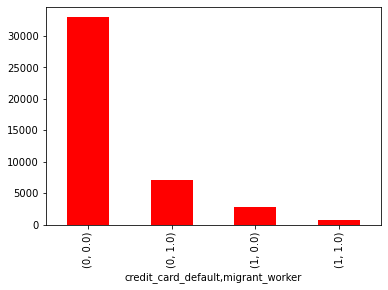

In [66]:
def plot_bar(data_imputed,column):
    print(df_1.groupby('credit_card_default')[column].value_counts().plot(kind = 'bar', color = "Red"))

plot_bar(df_1,'migrant_worker')

AxesSubplot(0.125,0.125;0.775x0.755)


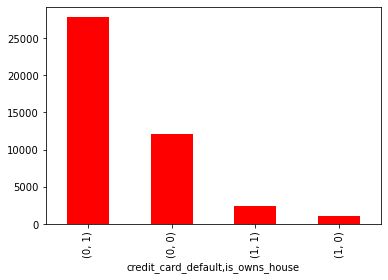

In [67]:
plot_bar(df_1,'is_owns_house')

AxesSubplot(0.125,0.125;0.775x0.755)


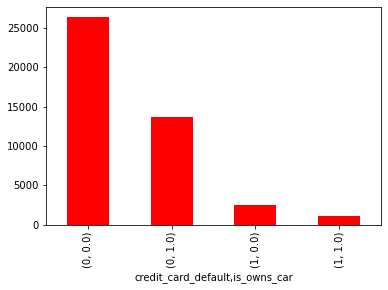

In [68]:
plot_bar(df_1,'is_owns_car')

AxesSubplot(0.125,0.125;0.775x0.755)


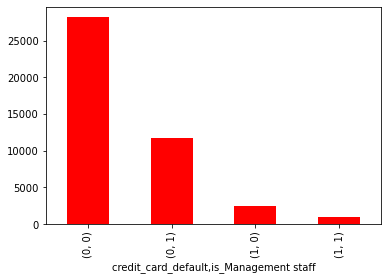

In [69]:
plot_bar(df_1,'is_Management staff')

AxesSubplot(0.125,0.125;0.775x0.755)


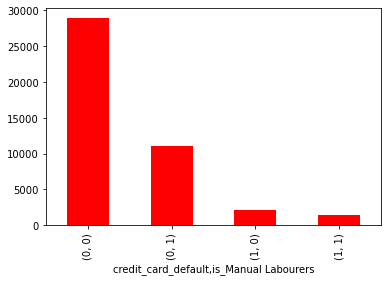

In [70]:
plot_bar(df_1,'is_Manual Labourers')

AxesSubplot(0.125,0.125;0.775x0.755)


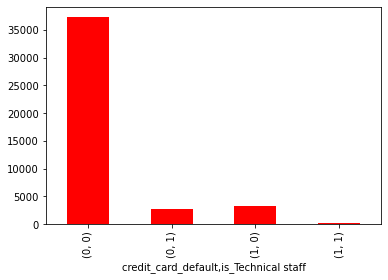

In [71]:
plot_bar(df_1,'is_Technical staff')

AxesSubplot(0.125,0.125;0.775x0.755)


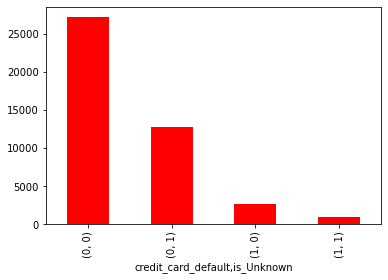

In [72]:
plot_bar(df_1,'is_Unknown')

AxesSubplot(0.125,0.125;0.775x0.755)


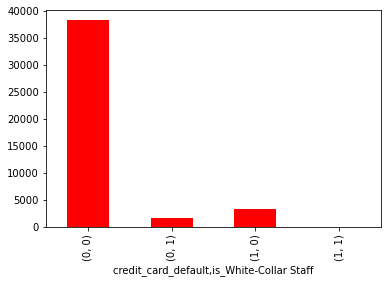

In [73]:
plot_bar(df_1,'is_White-Collar Staff')

AxesSubplot(0.125,0.125;0.775x0.755)


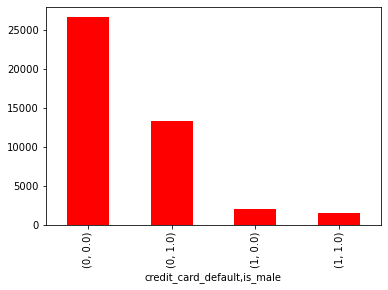

In [74]:
plot_bar(df_1,'is_male')

## DECISION TREE MODEL BUILDING

In [75]:
X = df_1[['age', 'no_of_children', 'net_yearly_income', 'no_of_days_employed',
       'total_family_members', 'migrant_worker', 'yearly_debt_payments',
       'credit_limit', 'credit_limit_used(%)', 'credit_score', 'prev_defaults',
       'default_in_last_6months', 'is_male', "is_prev_default",
       'is_owns_house', 'is_owns_car', 'is_Management staff',
       'is_Manual Labourers', 'is_Technical staff', 'is_Unknown',
       'is_White-Collar Staff']]
Y = df_1['credit_card_default']

from imblearn.over_sampling import SMOTE
os = SMOTE(random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=0)

columns = X_train.columns
os_data_X,os_data_y=os.fit_resample(X_train, y_train)

Since the distribution among class is not equal so we've performed smote to balance these classes.

In [76]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [77]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)  

DecisionTreeClassifier(random_state=42)

In [78]:
y_pred = clf.predict(X_test)

In [79]:
from sklearn import metrics
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [80]:
print(confusion_matrix(y_test, y_pred))
lg_reg_report = (classification_report(y_test, y_pred))
print(lg_reg_report)

[[7848  115]
 [ 126  613]]
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      7963
           1       0.84      0.83      0.84       739

    accuracy                           0.97      8702
   macro avg       0.91      0.91      0.91      8702
weighted avg       0.97      0.97      0.97      8702



In [81]:
def draw_cm( actual, predicted ):
    plt.figure(figsize=(9,9))
    cm = metrics.confusion_matrix( actual, predicted )
    custom_palette = sns.color_palette("Reds", n_colors=100)
    sns.heatmap(cm, annot=True,  fmt='.0f', xticklabels = ["Defaulter", "Not Defaulter"] , 
               yticklabels = ["Defaulter", "Not Defaulter"], cmap = custom_palette,vmin = 80, vmax = 11560)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Classification Matrix Plot', size = 15);
    plt.show()

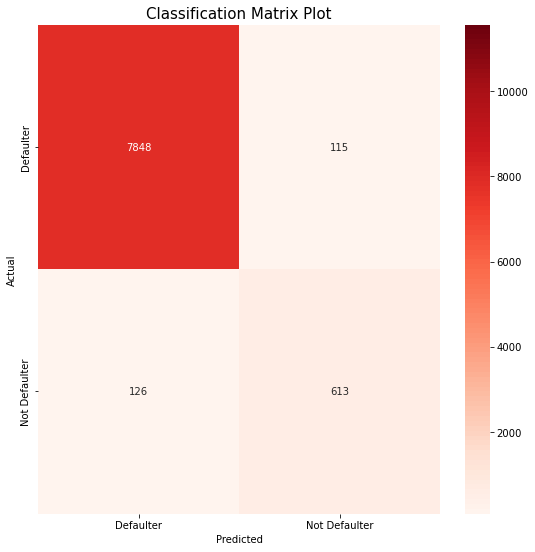

In [82]:
draw_cm( y_test, y_pred )

In [83]:
def measure_performance (clasf_matrix):
    measure = pd.DataFrame({
                        'sensitivity': [round(clasf_matrix[0,0]/(clasf_matrix[0,0]+clasf_matrix[0,1]),2)], 
                        'specificity': [round(clasf_matrix[1,1]/(clasf_matrix[1,0]+clasf_matrix[1,1]),2)],
                        'recall': [round(clasf_matrix[0,0]/(clasf_matrix[0,0]+clasf_matrix[0,1]),2)],
                        'precision': [round(clasf_matrix[0,0]/(clasf_matrix[0,0]+clasf_matrix[1,0]),2)],
                        'overall_acc': [round((clasf_matrix[0,0]+clasf_matrix[1,1])/
                                              (clasf_matrix[0,0]+clasf_matrix[0,1]+clasf_matrix[1,0]+clasf_matrix[1,1]),2)]
                       })
    return measure

In [84]:
cm = metrics.confusion_matrix(y_test, y_pred)

lg_reg_metrics_df = pd.DataFrame(measure_performance(cm))
print(lg_reg_metrics_df)

print( 'Total Accuracy sklearn: ',np.round( metrics.accuracy_score( y_test,y_pred), 2 ))

   sensitivity  specificity  recall  precision  overall_acc
0         0.99         0.83    0.99       0.98         0.97
Total Accuracy sklearn:  0.97


In [85]:
from sklearn.model_selection import cross_val_score, KFold
# Define the number of folds (e.g., 5)
k_folds = 5

# Create a KFold object to control the splitting of data
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

# Perform cross-validation and calculate accuracy scores
cross_val_scores = cross_val_score(clf, X, Y, cv=kf)

In [86]:
for fold, accuracy in enumerate(cross_val_scores, start=1):
    print(f"Fold {fold} Accuracy: {accuracy:.2f}")

mean_accuracy = cross_val_scores.mean()
print(f"Mean Accuracy: {mean_accuracy:.2f}")

Fold 1 Accuracy: 0.97
Fold 2 Accuracy: 0.97
Fold 3 Accuracy: 0.97
Fold 4 Accuracy: 0.97
Fold 5 Accuracy: 0.97
Mean Accuracy: 0.97


The output shows that your decision tree model achieved a consistent accuracy of approximately 97% across all five folds of the cross-validation. This is a good sign and indicates that your model is likely performing well and not overfitting to a specific training-test split. The mean accuracy of 0.97 also reinforces the idea that your model is performing consistently well on different subsets of the data.

## Random Forest Classifier

In [87]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [88]:
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [89]:
y_pred_rf = rf_classifier.predict(X_test)


In [90]:
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"Random Forest Accuracy: {accuracy_rf:.2f}")

Random Forest Accuracy: 0.98


In [91]:
class_report_rf = classification_report(y_test, y_pred_rf)
print("Random Forest Classification Report:")
print(class_report_rf)

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      7963
           1       0.99      0.76      0.86       739

    accuracy                           0.98      8702
   macro avg       0.98      0.88      0.92      8702
weighted avg       0.98      0.98      0.98      8702



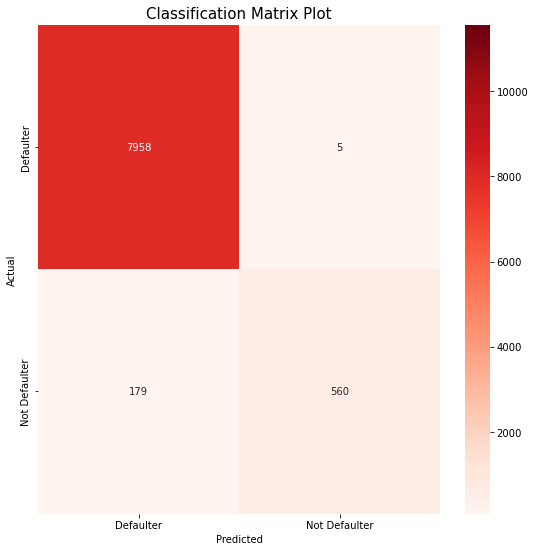

In [92]:
draw_cm(y_test, y_pred_rf )

<b> The Random Forest outperforms the Decision Tree in terms of precision and F1-Score, indicating that it is better at correctly classifying defaults. However, the Decision Tree has a slightly higher recall, suggesting it captures a few more actual defaults. Both models exhibit high accuracy and specificity, which is generally desirable for credit default analysis. The choice between these models depends on the specific business objectives and trade-offs between precision and recall. </b>